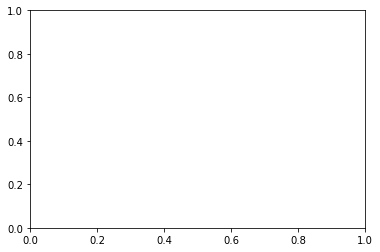

In [1]:
#Imports
from labcams import parse_cam_log
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.chdir(r'C:\Users\chris\int-brain-lab\wfield\wfield')
from  wfield import *
import imageio
import math
from matplotlib import cm
import matplotlib.colors as mplc
from matplotlib.lines import Line2D
import seaborn as sns
from analyses import *


In [2]:
#get_data
subject = 'CSK-im-002'
baseDir = r'H:\imaging_data'
os.chdir(pjoin(baseDir,subject))
dates = os.listdir()
## iterate through dates for each subject
date = '2021-01-16'
localdisk = pjoin(baseDir,subject,date)

behavior = fetch_task_data(subject,date)
behavior = behavior[behavior['choice']!=0].reset_index() #drop trials where there was no response
U = np.load(pjoin(localdisk,'U.npy'))# load spatial components
SVTcorr = np.load(pjoin(localdisk,'SVTcorr.npy'))# load hemodynamic corrected temporal components
SVT =  np.load(pjoin(localdisk,'SVT.npy'))# load  normal temporal components

# the allen atlas and brain mask for finding which pixels corresponds to which area
# this is in original allen space, to put in image space use do_transform=True
atlas, area_names, brain_mask = atlas_from_landmarks_file(pjoin(localdisk,'dorsal_cortex_landmarks.JSON'))
ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')

#the transform to apply to the images to put them into atlas space
transform = load_allen_landmarks(pjoin(localdisk, 'dorsal_cortex_landmarks.JSON'))['transform']
lmarks = load_allen_landmarks(pjoin(localdisk, 'dorsal_cortex_landmarks.JSON'))
nref_regions = allen_transform_regions(None,ccf_regions,
                                resolution=lmarks['resolution'],
                                bregma_offset=lmarks['bregma_offset'])

stack = SVDStack(U,SVTcorr)
stack.set_warped(True,M = lmarks['transform'])# put the components into atlas space
# mask the pixels outside of the brain outline.
from wfield.imutils import mask_to_3d
# transform the brain outline to image coordinates
b_outline = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])
mask = contour_to_mask(*b_outline.T,dims = U.shape[:-1])
#create a 3d mask of the brain outline
mask3d = mask_to_3d(mask,shape = np.roll(stack.U_warped.shape,1))
# set pixels outside the brain outline to zero
stack.U_warped[~mask3d.transpose([1,2,0])] = 0   

#sync up the behavior and grab a few things for analysis
sync_behavior = sync_to_task(localdisk)
mask = ['times' in key for key in behavior.keys()]
time_df = behavior[behavior.keys()[mask]]
frame_df = pd.DataFrame(columns=time_df.keys())
for (columnName, columnData) in time_df.iteritems():
    frame_df[columnName] = time_to_frames(sync_behavior,localdisk,np.array(columnData),dropna=False)
frame_df = frame_df.astype(np.int64)


C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrastRight'][np.isnan(df['contrastRight'])] = 0
C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrastLeft'][np.isnan(df['contrastLeft'])] = 0
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

<IPython.core.display.Javascript object>


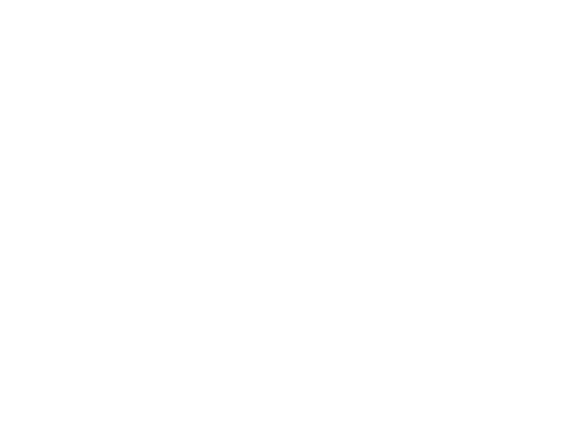

In [3]:
%matplotlib notebook
#make sure the atlas and the stacka re in the same image space
plt.figure()
alpha=.75
temp_at = atlas != 0
plt.imshow(temp_at/100 * (1.0 - alpha) + stack.U_warped.mean(axis=2) * alpha)


In [4]:
U=stack.U_warped
SVT=stack.SVT
def plot_area_sample(fig,ax,U, SVT, behavior, sync_behavior, allen_area, atlas,localdisk, plot_sec=15):
    # first get all the frames for all the events and store inf frame_df
    use_trials = behavior.iloc[:90]
    frame_df = time_to_frameDF(use_trials,sync_behavior,localdisk)
    # for the first plot, get the first 10 seconds, and the events that happen then
    first_event = frame_df['stimOn_times'][0]
    first_10 = reconstruct(U,SVT[:,first_event:first_event+plot_sec*30]) # ten seconds at 30fps
    first_events = frame_df[frame_df <= first_event+plot_sec*30] - first_event
    first_events.drop(['goCue_times','goCueTrigger_times', 'feedback_times'],axis='columns',inplace=True)

    x = np.arange(plot_sec*30)
    area_r = allen_area.label*-1
    area_l = allen_area.label
    first_10_l = first_10[:,atlas==area_l].mean(axis=1)
    first_10_r = first_10[:,atlas==area_r].mean(axis=1)
    
    norm = mplc.Normalize(vmin=0,vmax=len(area_list))
    color1 = cm.tab20(norm(0))
    color2 = cm.tab20(norm(1))
    fig.suptitle(allen_area.acronym)
    ax.plot(x/30,first_10_l,color=color1)
    ax.plot(x/30,first_10_r,color=color2)

    event_colors = ['c','g','orange','k']
    cnt=0
    for (event,times) in first_events.iteritems():
        ax.vlines(times/30,np.min(first_10_r),np.max(first_10_l),colors = event_colors[cnt])
        cnt+=1

    colors = event_colors + [color1,color2]
    labels = first_events.keys().tolist()+['Right_hem','Left_hem']
    make_legend(ax,colors,labels)
    # ax.set_xlabel('time (s)')
    ax.set_ylabel('df/f')
    ax.set_xlim(0,plot_sec)
    # return np.vstack((first_10_l,first_10_r), first_events


def plot_trial_sample(fig, ax, stack, behavior, frame_df, pixel_mask, baseline_correct=True, pre=20,post=60, trial_choice=np.arange(90)):
    
    use_behavior = behavior.iloc[trial_choice]
    frame_df = frame_df.astype(np.int64)
    stimOns = np.array(frame_df.stimOn_times)[trial_choice]
    trials = np.empty([len(stimOns),pre+post])
    pixel_val = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
    for i in tqdm(range(len(stimOns))):
        stim = stimOns[i]
        trials[i,:] = pixel_val[stim-pre:stim+post]
    trials_mean = np.mean(trials,axis=0)
    trials=np.concatenate([trials,trials_mean.reshape(1,-1)],axis=0)
    if baseline_correct:
        baseline_act = np.empty([len(stimOns),3])
        pixel_act = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
        for i in range(len(stimOns)):
            stim = stimOns[i]
            baseline_act[i,:] = pixel_val[stim-3:stim]
        
        baseline_act = np.append(baseline_act.mean(axis=1),np.mean(baseline_act))
        baseline_act = baseline_act[:,np.newaxis]
        baseline_act = np.repeat(baseline_act,trials.shape[1],axis=1)
        trials =  trials-baseline_act
    norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.05,vmax = .08)
    ax = sns.heatmap(trials,cmap='RdBu_r',cbar=True,square=False,ax=ax,norm=norm)

    # cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    # cb.set_label('df/f')
    ax.axvline(pre,0,len(trial_choice),color='k')
    ax.set_yticks(np.arange(trials.shape[0])+.5)
    ax.set_yticklabels(behavior.loc[trial_choice,'signedContrast'].astype(str).append(pd.Series('mean')),rotation=0)
    ax.set_xticks(np.arange(0,pre+post,10))
    ax.set_xlim(0,pre+post)
    ax.set_xticklabels(np.around(np.arange(-pre,post,10)/15,decimals=2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('trial contrasts')
    return trials


def plot_signal_summary(fig,U, SVT, behavior, sync_behavior, allen_area, allen_atlas,localdisk,ccf_regions):
    """
    plot a summary of the signal through stages of processing for a single brain area. First a few
    traces of raw df/f, then some trials, and an average trace.
    Inputs:
        U: spatial components
        SVT: hemodynamically corrected temporal components
        behavior: dataframe with behavioral events and timestamps of len(nTrials)
        sync_behavior: dataframe with the sync information btw times and frames
        allen_area: pandas series taking one row of the ccf_regions dataframe
        allen_atlas: 540x640 array with each area marked by its unique label
    """
    # fig = plt.figure(constrained_layout=True)
    use_behavior = behavior.iloc[np.arange(90)]
    mask = ['times' in key for key in use_behavior.keys()]
    time_df = use_behavior[use_behavior.keys()[mask]]
    frame_df = pd.DataFrame(columns=time_df.keys())
    for (columnName, columnData) in time_df.iteritems():
        frame_df[columnName] = time_to_frames(sync_behavior,localdisk,np.array(columnData),dropna=False)
    frame_df = frame_df.astype(np.int64)
    stimOns = np.array(frame_df.stimOn_times)

    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])
    print('plotting a sample of the raw trace...')
    plot_trace_sample(fig,ax1,U, SVT, behavior, sync_behavior, allen_area, allen_atlas,localdisk)
    print('plotting the first 90 trials...')
    plot_trial_sample(fig,ax2,U, SVT, behavior, sync_behavior, allen_area, allen_atlas,localdisk)
    print('plotting the PSTHs...')
    x,psth,ste = whole_brain_peth(stimOns,U,SVT,window=[-10,60])
    plot_multi_psth(ax3,x,psth,ste,allen_atlas,[allen_area.label,allen_area.label*-1],ccf_regions)
    # plt.show(block=False)
def make_screen_image(ax,behavior,frame_df,index,event_frames,event_type = 'stimOn_times'):
    behavior = behavior
def make_single_trial_movie(stack,behavior,frame_df, pre=10,post=30, trial=100,event_type='stimOn_times'):
    event_frame = frame_df[event_type].iloc[trial]
def _handle_sparse(im,shape):
    if issparse(im):
        if shape is None:
            raise ValueError('Supply shape = [H,W] when using sparse arrays')
        im = np.asarray(im.todense()).reshape(shape)
    return im

def fetch_trial_event_names(behavior,frame_df,trial):
    trial_info = behavior.iloc[trial]
    trial_frames = frame_df.iloc[trial]
    trial_events = np.array(trial_frames[['stimOn_times','firstMovement_times','response_times', 'feedback_times']])
    stim_on = str(trial_info['signedContrast']*100)+'%'
    if trial_info['choice'] == 1:
        firstMovement = 'first move right =>'
        response = 'right response =>'
    elif trial_info['choice'] == -1:
        firstMovement = '<-first move left'
        response = '<-left response'
    if trial_info['feedbackType'] == -1:
        feedback = 'error'
    else:
        feedback = 'correct'
    event_names = [stim_on,firstMovement,response,feedback]
    return trial_events-trial_events[0], event_names

def save_movie(data,filename,event_frames, event_names,interval = 100,dpi = 90,shape=None,**kwargs):
    '''
    Replace nb_play_movie with this to save to a file.

    Example:

    nb_save_movie(tmp[:,:,::-1],
                  filename = '~/Desktop/example.avi',
                  clim = [.06,.2],
                  extent = extent,
                  cmap = 'hot', 
                  alpha = 0.5);
    '''
    from tqdm import tqdm
    from matplotlib.animation import FuncAnimation
    def animate(frame,event_frames,event_names):
        global pbar
        pbar.update(1)
        i = _handle_sparse(data[frame],shape = shape)
        im.set_data(i.squeeze())     
        ax=plt.gca()
        if '-' in event_names[0]:
            textX = 0
        else:
            textX = 400
        for i in range(len(event_frames)):
            if frame == event_frames[i]:
                txt=ax.text(textX,20*i,event_names[i])
            else:
                txt=ax.text(textX,20*i,'')
        return im,
    fig = plt.gcf()
    i = _handle_sparse(data[0],shape = shape)
    im = plt.imshow(i.squeeze(),**kwargs)
    plt.colorbar()
    animation = FuncAnimation(
        fig,
        animate,
        np.arange(data.shape[0]),
        fargs=[event_frames,event_names],
        interval=interval)
    global pbar
    pbar = tqdm(desc = 'Saving movie ',total=data.shape[0])
    animation.save(filename, dpi=dpi)
    pbar.close()
    plt.show(block=False)
    print('Saved to {0}'.format(filename))    

In [7]:
%matplotlib notebook
pre=3
post=10
contrasts = np.unique(behavior['signedContrast'])
for contrast in contrasts:
    trial = behavior[behavior['signedContrast'] ==contrast].index[9]
    event_type='stimOn_times'
    event_frame = frame_df[event_type].iloc[trial]
    movie = reconstruct(stack.U_warped,stack.SVT[:,event_frame-pre:event_frame+post])
    ## baseline correction
    baseline = np.mean(movie[pre-3:pre,:,:],axis=0)
    movie=movie-baseline
    plt.figure(figsize=(10,10))
    plt.axis('off')
    for i,r in nref_regions.iterrows():
        plt.plot(r['left_x'],r['left_y'],color='k',lw=0.3)
        plt.plot(r['right_x'],r['right_y'],color='k',lw=0.3)

    event_frames,event_names = fetch_trial_event_names(behavior,frame_df,trial)
    print(os.getcwd())
    save_movie(movie,'example_trial_{}.gif'.format(contrast),event_frames+pre,event_names,interval = 1000,clim=(-.10,.10),cmap='RdBu_r')


<IPython.core.display.Javascript object>

H:\imaging_data\CSK-im-002



Saving movie :  23%|███████████████▋                                                    | 3/13 [00:00<00:00, 19.28it/s]MovieWriter stderr:
example_trial_-1.0.gif: Permission denied



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '900x900', '-pix_fmt', 'rgba', '-r', '1.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'example_trial_-1.0.gif']' returned non-zero exit status 1.

In [ ]:
event_names



In [ ]:
def plot_section_sample(fig,ax1,ax2,U, SVT, behavior, frame_df, pixel_masks, atlas, plot_sec=20):


    first_event = frame_df['stimOn_times'].iloc[70]
    first_10 = reconstruct(U,SVT[:,first_event:int(first_event+plot_sec*30)]) # ten seconds at 30fps
    first_events = frame_df[frame_df <= first_event+plot_sec*30] - first_event
    first_events.drop(['goCue_times','goCueTrigger_times', 'feedback_times'],axis='columns',inplace=True)

    x = np.arange(plot_sec*30)
    first_10_all = []
    norm = mplc.Normalize(vmin=0,vmax=len(pixel_masks)-1)
    colors = []
    roi_labels = []
    image = np.zeros_like(atlas)
    image[atlas!=0] = 1
    image = np.stack([image,image,image,np.ones_like(image)],axis=2)
    #     fig.suptitle(allen_area.acronym)
    for i in range(len(pixel_masks)):
        color = cm.tab10(norm(i))

        first_10_all.append(first_10[:,np.where(pixel_masks[i])[0],np.where(pixel_masks[i])[1]].mean(axis=1))
        ax1.plot(x/30,first_10_all[i],color=color)
        colors.append(color)
        roi_labels.append('ROI {}'.format(i+1))

        image[pixel_masks[i],:] = color
    ax2.imshow(image)
    event_colors = ['c','g','orange','k']
    cnt=0
    for (event,times) in first_events.iteritems():
        if event == 'stimOn_times':
            for i in range(len(times.dropna())):
                ax1.text(times[i]/30,.08,behavior.loc[i,'signedContrast'].tolist())
        ax1.vlines(times/30,.07,-.04,colors = event_colors[cnt])
        cnt+=1
    all_colors = event_colors + colors
    labels = first_events.keys().tolist()+roi_labels
    make_legend(ax1,all_colors,labels,location='upper left')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('df/f')
    ax1.set_xlim(0,plot_sec)
    ax1.set_ylim(-0.04,.08)


In [ ]:
def plot_section_sample(fig,ax1,ax2,U, SVT, behavior, frame_df, pixel_masks, atlas, frame_range=[1000,1200]):


    start = frame_range[0]
    end = frame_range[1]
    first_10 = reconstruct(U,SVT[:,start:end])
    first_events = frame_df[frame_df >= start]
    first_events = first_events[first_events<end].dropna()
    first_events.drop(['goCue_times','goCueTrigger_times', 'feedback_times'],axis='columns',inplace=True)


    x = np.arange(start,end)
    first_10_all = []
    norm = mplc.Normalize(vmin=0,vmax=len(pixel_masks)-1)
    colors = []
    roi_labels = []
    image = np.zeros_like(atlas)
    image[atlas!=0] = 1
    image = np.stack([image,image,image,np.ones_like(image)],axis=2)
    #     fig.suptitle(allen_area.acronym)
    for i in range(len(pixel_masks)):
        color = cm.tab10(norm(i))

        first_10_all.append(first_10[:,np.where(pixel_masks[i])[0],np.where(pixel_masks[i])[1]].mean(axis=1))
        ax1.plot(x,first_10_all[i],color=color)
        colors.append(color)
        roi_labels.append('ROI {}'.format(i+1))

        image[pixel_masks[i],:] = color
    ax2.imshow(image)
    event_colors = ['c','g','orange','k']
    cnt=0
    for (event,times) in first_events.iteritems():
        if event == 'stimOn_times':
            for i in range(len(times.dropna())):
                ax1.text(times.iloc[i],.08,behavior.loc[i,'signedContrast'].tolist())
        ax1.vlines(times,.07,-.04,colors = event_colors[cnt])
        cnt+=1
    ax1.set_xticks(np.linspace(start,end,9))
    ax1.set_xticklabels([str(i) for i in np.round(np.linspace(start,end,9)/15,2)])
    all_colors = event_colors + colors
    labels = first_events.keys().tolist()+roi_labels
    make_legend(ax1,all_colors,labels,location='upper left')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('df/f')
    ax1.set_xlim(start,end)
    ax1.set_ylim(-0.04,.08)

    ax2.axis('off')


In [ ]:
fig,axs = plt.subplots(2,1)
ax1=axs[0]
ax2=axs[1]
plt.tight_layout()
frame_range=[1000,1200]
pixel_masks = [ant_visR,ant_visL,lat_moR]
start = frame_range[0]
end = frame_range[1]
# first_10 = reconstruct(U,SVT[:,start:end])
first_events = frame_df[frame_df >= start]
first_events = first_events[first_events<end].dropna()
first_events.drop(['goCue_times','goCueTrigger_times', 'feedback_times'],axis='columns',inplace=True)


x = np.arange(start,end)
first_10_all = []
norm = mplc.Normalize(vmin=0,vmax=len(pixel_masks)-1)
colors = []
roi_labels = []
image = np.zeros_like(atlas)
image[atlas!=0] = 1
image = np.stack([image,image,image,np.ones_like(image)],axis=2)
#     fig.suptitle(allen_area.acronym)
for i in range(len(pixel_masks)):
    color = cm.tab10(norm(i))

    first_10_all.append(first_10[:,np.where(pixel_masks[i])[0],np.where(pixel_masks[i])[1]].mean(axis=1))
    ax1.plot(x,first_10_all[i],color=color)
    colors.append(color)
    roi_labels.append('ROI {}'.format(i+1))

    image[pixel_masks[i],:] = color
ax2.imshow(image)
event_colors = ['c','g','orange','k']
cnt=0
for (event,times) in first_events.iteritems():
    if event == 'stimOn_times':
        for i in range(len(times.dropna())):
            ax1.text(times.iloc[i]/30,.08,behavior.loc[i,'signedContrast'].tolist())
    ax1.vlines(times,.07,-.04,colors = event_colors[cnt])
    cnt+=1
ax1.set_xticks(np.linspace(start,end,9))
ax1.set_xticklabels = [str(i) for i in np.round(np.linspace(start,end,9)/15,2)]
all_colors = event_colors + colors
labels = first_events.keys().tolist()+roi_labels
make_legend(ax1,all_colors,labels,location='upper left',bbox_to_anchor = [.7,-.2])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('df/f')
ax1.set_xlim(start,end)
ax1.set_ylim(-0.04,.08)

ax2.axis('off')

In [ ]:
for (event,times) in first_events.iteritems():
    if event == 'stimOn_times':
        for i in range(len(times.dropna())):
            ax1.text(times.iloc[i]/30,.08,behavior.loc[i,'signedContrast'].tolist())

In [ ]:
fig,axs1 = plt.subplots(3,1,figsize = [12,5],constrained_layout=True)
pre=5
fig2,axs2 = plt.subplots(2,1)
# R Visual anterior
ant_visR = np.zeros_like(atlas).astype(bool)
ant_visR[370:390,470:490] = True
# L Visual Anterior
ant_visL = np.zeros_like(atlas).astype(bool)
ant_visL[370:390,150:170] = True
# R lateral motor
lat_moR = np.zeros_like(atlas).astype(bool)
lat_moR[200:220,150:170] = True
# L Visual posterior
pos_visL = np.zeros_like(atlas).astype(bool)
pos_visL[460:480,180:200] = True
bregma_offset = lmarks['bregma_offset']
pixel_masks = [ant_visR,ant_visL,lat_moR]
plot_section_sample(fig,axs1[0],axs2[0],stack.U_warped,SVTcorr,behavior,frame_df,pixel_masks,atlas)
plot_section_sample(fig,axs1[1],axs2[1],stack.U_warped,SVT[:,1::2],behavior,frame_df,pixel_masks,atlas)
plot_section_sample(fig,axs1[2],axs2[1],stack.U_warped,SVT[:,::2],behavior,frame_df,pixel_masks,atlas)

In [ ]:
fig,axs1 = plt.subplots(2,1,figsize = [12,5],constrained_layout=True)
pre=5
fig2,axs2 = plt.subplots(2,1)
# R Visual anterior
ant_visR = np.zeros_like(atlas).astype(bool)
ant_visR[400:420,460:480] = True
# L Visual Anterior
ant_visL = np.zeros_like(atlas).astype(bool)
ant_visL[400:420,180:200] = True
# R lateral motor
lat_moR = np.zeros_like(atlas).astype(bool)
lat_moR[200:220,150:170] = True
# L Visual posterior
pos_visL = np.zeros_like(atlas).astype(bool)
pos_visL[460:480,180:200] = True
bregma_offset = lmarks['bregma_offset']
pixel_masks = [ant_visR,ant_visL,lat_moR]
plot_section_sample(fig,axs1[0],axs2[0],stack.U_warped,stack.SVT,behavior,frame_df,pixel_masks,atlas)
# plot_section_sample(fig,axs1[1],axs2[1],stack.U_warped,stack.SVT,behavior,frame_df,[atlas==33, atlas==-33],atlas)

In [ ]:
fig,axs1 = plt.subplots(2,1,figsize = [12,5],constrained_layout=True)
fig2,axs2 = plt.subplots(2,1)
fig3,axs3 = plt.subplots(2,1)
# Right ALM
alm_R = np.zeros_like(atlas).astype(bool)
alm_R[140:160,440:460] = True
# Left ALM
alm_L = np.zeros_like(atlas).astype(bool)
alm_L[140:160,180:200] = True
# left, posterior MOs
mosP_L = np.zeros_like(atlas).astype(bool)
mosP_L[250:270,260:280] = True
# left, medial MOs
mosM_L = np.zeros_like(atlas).astype(bool)
mosM_L[140:160,260:280] = True
# Right, posterior MOs
mosP_R = np.zeros_like(atlas).astype(bool)
mosP_R[270:290,390:410] = True

x,peth, std = whole_brain_peth(frame_df['response_times'][:90],U,SVT,window=[-pre,post],smoothing=None)
pixel_masks = [alm_L,mosP_L,mosM_L]
plot_section_sample(fig,axs1[0],axs2[0],stack.U_warped,stack.SVT,behavior,frame_df,pixel_masks,atlas)
plot_section_sample(fig,axs1[1],axs2[1],stack.U_warped,stack.SVT,behavior,frame_df,[atlas==4],atlas)
plot_multi_psth(axs3[0],x,peth,std,atlas,pixel_masks)
plot_multi_psth(axs3[1],x,peth,std,atlas,[atlas==4])

In [ ]:
fig,axs1 = plt.subplots(2,1,figsize = [12,5],constrained_layout=True)
fig2,axs2 = plt.subplots(2,1)
fig3,axs3 = plt.subplots(2,1)
# Left ALM
alm_L = np.zeros_like(atlas).astype(bool)
alm_L[140:160,210:230] = True
# left, posterior MOs
som_L = np.zeros_like(atlas).astype(bool)
som_L[320:340,140:160] = True
# right retrosplenial
rsp_R = np.zeros_like(atlas).astype(bool)
rsp_R[400:420,380:400] = True

x,peth, std = whole_brain_peth(stimOns,U,SVT,window=[-pre,post],smoothing=None)
bregma_offset = lmarks['bregma_offset']
pixel_masks = [alm_L,som_L,rsp_R]
plot_section_sample(fig,axs1[0],axs2[0],stack.U_warped,stack.SVT,behavior,frame_df,pixel_masks,atlas)
plot_section_sample(fig,axs1[1],axs2[1],stack.U_warped,stack.SVT,behavior,frame_df,[atlas==4],atlas)
plot_multi_psth(axs3[0],x,peth,std,atlas,pixel_masks)
plot_multi_psth(axs3[1],x,peth,std,atlas,[atlas==4])


In [ ]:
# def plot_trial_sample(fig, ax, U, SVT, behavior, frame_df, pixel_mask, trial_choice=np.arange(90),pre=10,post=30):
    
#     use_behavior = behavior.iloc[trial_choice]
#     frame_df = frame_df.iloc[:len(use_behavior)].astype(np.int64)
#     stimOns = np.array(frame_df.stimOn_times)
#     trials = np.zeros([len(frame_df),pre+post])
#     for i in tqdm(range(len(stimOns))):
#         stim = stimOns[i]
#         trial_im = reconstruct(U,SVT[:,stim-pre:stim+post])
# #         if behavior.loc[i,'signedContrast'] < 0:
# #             trials[i,:] = trial_im[:,np.where(pixel_mask)[0],np.where(pixel_mask)[1]].mean(axis=1)*-1
# #         else:
#         trials[i,:] = trial_im[:,np.where(pixel_mask)[0],np.where(pixel_mask)[1]].mean(axis=1)
            
#     norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.05,vmax = .08)
#     ax = sns.heatmap(trials,cmap='RdBu_r',cbar=True,square=False,ax=ax,norm=norm)

#     # cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
#     # cb.set_label('df/f')
#     ax.axvline(10,0,90,color='k')
#     ax.set_yticks(np.arange(trials.shape[0])+.5)
#     ax.set_yticklabels(behavior.loc[:trials.shape[0]-1,'signedContrast'],rotation=0)
#     ax.set_xticks(np.arange(0,pre+post,10))
#     ax.set_xlim(0,pre+post)
#     ax.set_xticklabels(np.around(np.arange(-pre,post,10)/30,decimals=2))
#     # ax.set_xlabel('frames @30fps')
#     ax.set_ylabel('trial contrasts')

In [ ]:
axs[0,0]

In [ ]:
fig,axs = plt.subplots(1,2,constrained_layout = True)
U=stack.U_warped
SVT=stack.SVT
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice=behavior[behavior['feedbackType']==-1].index
pre=10
post=30
plot_trial_sample(fig, axs[0], stack, behavior, frame_df, pixel_mask1,trial_choice=trial_choice, pre=10,post=30)
axs[0].set_title('left visual spot')
plot_trial_sample(fig, axs[1], stack, behavior, frame_df, pixel_mask2, trial_choice=trial_choice, pre=10,post=30)
axs[1].set_title('right visual spot')


In [ ]:
fig,axs = plt.subplots(2,2,constrained_layout = True)
U=stack.U_warped
SVT=stack.SVT
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] >.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] <-.1)].index
trial_choice_correct = np.random.choice(trial_choice_correct,len(trial_choice_error))
pre=10
post=30
plot_trial_sample(fig, axs[0,0], stack, behavior, frame_df, pixel_mask1,trial_choice=trial_choice_error, pre=10,post=30)
axs[0,0].set_title('left visual spot error')
plot_trial_sample(fig, axs[0,1], stack, behavior, frame_df, pixel_mask1, trial_choice=trial_choice_correct, pre=10,post=30)
axs[0,1].set_title('left visual spot correct')
plot_trial_sample(fig, axs[1,0], stack, behavior, frame_df, pixel_mask2,trial_choice=trial_choice_error, pre=10,post=30)
axs[1,0].set_title('right visual spot error')
plot_trial_sample(fig, axs[1,1], stack, behavior, frame_df, pixel_mask2, trial_choice=trial_choice_correct, pre=10,post=30)
axs[1,1].set_title('right visual spot correct')

In [ ]:
fig,axs = plt.subplots(2,2,constrained_layout = True)
U=stack.U_warped
SVT=stack.SVT
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] <-.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] <-.1)].index
trial_choice_correct = np.random.choice(trial_choice_correct,len(trial_choice_error))
pre=10
post=30
plot_trial_sample(fig, axs[0,0], stack, behavior, frame_df, pixel_mask1,trial_choice=trial_choice_error, pre=10,post=30)
axs[0,0].set_title('left visual spot error')
plot_trial_sample(fig, axs[0,1], stack, behavior, frame_df, pixel_mask1, trial_choice=trial_choice_correct, pre=10,post=30)
axs[0,1].set_title('left visual spot correct')
plot_trial_sample(fig, axs[1,0], stack, behavior, frame_df, pixel_mask2,trial_choice=trial_choice_error, pre=10,post=30)
axs[1,0].set_title('right visual spot error')
plot_trial_sample(fig, axs[1,1], stack, behavior, frame_df, pixel_mask2, trial_choice=trial_choice_correct, pre=10,post=30)
axs[1,1].set_title('right visual spot correct')

In [ ]:
fig,axs = plt.subplots(1,2,constrained_layout = True)
U=stack.U_warped
SVT=stack.SVT
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice=np.arange(20)
pre=10
post=30
plot_trial_sample(fig, axs[0], stack, behavior, frame_df, pixel_mask1,trial_choice=trial_choice, pre=10,post=30)
axs[0].set_title('left visual spot')
plot_trial_sample(fig, axs[1], stack, behavior, frame_df, pixel_mask2, trial_choice=trial_choice, pre=10,post=30)
axs[1].set_title('right visual spot')


In [ ]:
# Left ALM
alm_L = np.zeros_like(atlas).astype(bool)
alm_L[140:160,210:230] = True
# left, posterior MOs
som_L = np.zeros_like(atlas).astype(bool)
som_L[320:340,140:160] = True
# right retrosplenial
rsp_R = np.zeros_like(atlas).astype(bool)
rsp_R[400:420,380:400] = True
mask_list = [alm_L,som_L,rsp_R]
# x,peth, std = whole_brain_peth(stimOns,U,SVT,window=[-pre,post],smoothing=None)

def plot_multi_psth(ax,x, psth, ste, atlas, mask_list,format_axis=True):
    '''
    Takes the output of whole_brain_peth and plots psth traces for a subset of areas.
    x,psth,std: the output of whole_brain_peth
    atlas: (numpy array) the transformed atlas returned by 
                      atlas_from_landmarks_file(<landmarks_file>,do_transform=True)
    area_list: the list off integer area codes to index into the atlas
    '''
    
    # fig,ax = plt.subplots(1,1)
    norm = mplc.Normalize(vmin=0,vmax=len(mask_list)-1)
    cnt=0
    clist = []
    labels = []
    for area in mask_list:
        color = cm.tab10(norm(cnt))
        temp_df = psth[:,np.where(area)[0],np.where(area)[1]].mean(axis=1)
        temp_ste = ste[:,np.where(area)[0],np.where(area)[1]].mean(axis=1)
        ax.plot(x,temp_df,color=color)
        ax.fill_between(x,temp_df+temp_ste,temp_df-temp_ste,color=color,alpha=.5)
        clist.append(color)
        labels.append('ROI {}'.format(cnt+1))
        cnt+=1
    if format_axis:
        make_legend(ax,clist,labels, location='upper right',bbox_to_anchor=(.99,.99))
        ax.set_xlim(np.min(x),np.max(x))
        ax.set_xticks([0,15,30])
        ax.set_xticklabels([0,.5,1])
        ax.axvline(0,0,1,color='k')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('df/f')
        # plt.show(block=False)
fig,ax = plt.subplots(1,1)
plot_multi_psth(ax,x,peth,std,atlas,mask_list)

In [ ]:
def area_sub_trial_sample_d2(ax,pixel_masks,trial_choice,stack,behavior,frame_df,baseline_correct=True):
    pre=10
    post=30
    side_trials = []
    for pixel_mask in pixel_masks:
        use_behavior = behavior.iloc[trial_choice]
        frame_df = frame_df.astype(np.int64)
        stimOns = np.array(frame_df.stimOn_times)[trial_choice]
        trials = np.empty([len(stimOns),pre+post])
        pixel_val = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
        for i in tqdm(range(len(stimOns))):
            stim = stimOns[i]
            trials[i,:] = pixel_val[stim-pre:stim+post]
        trials_mean = np.mean(trials,axis=0)
        trials=np.concatenate([trials,trials_mean.reshape(1,-1)],axis=0)
        if baseline_correct:
            baseline_act = np.empty([len(stimOns),3])
            pixel_act = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
            for i in range(len(stimOns)):
                stim = stimOns[i]
                baseline_act[i,:] = pixel_val[stim-3:stim]

            baseline_act = np.append(baseline_act.mean(axis=1),np.mean(baseline_act))
            baseline_act = baseline_act[:,np.newaxis]
            baseline_act = np.repeat(baseline_act,trials.shape[1],axis=1)
            trials =  trials-baseline_act  
            
        side_trials.append(np.diff(trials,axis=1))

    trials = np.subtract(side_trials[0],side_trials[1])       
  
    norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.01,vmax = .01)
    ax = sns.heatmap(trials,cmap='RdBu_r',cbar=True,square=False,ax=ax,norm=norm,cbar_kws={'label': 'd2f/f'})

    # cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    # cb.set_label('df/f')
    ax.axvline(pre,0,len(trial_choice),color='k')
    ax.set_yticks(np.arange(trials.shape[0])+.5)
    ax.set_yticklabels(behavior.loc[trial_choice,'signedContrast'].astype(str).append(pd.Series('mean')),rotation=0)
    ax.set_xticks(np.arange(0,pre+post,10))
    ax.set_xlim(0,pre+post)
    ax.set_xticklabels(np.around(np.arange(-pre,post,10)/15,decimals=2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('trial contrasts')
def area_sub_trial_sample(ax,pixel_masks,trial_choice,stack,behavior,frame_df,baseline_correct=True):
    pre=10
    post=30
    side_trials = []
    for pixel_mask in pixel_masks:
        use_behavior = behavior.iloc[trial_choice]
        frame_df = frame_df.astype(np.int64)
        stimOns = np.array(frame_df.stimOn_times)[trial_choice]
        trials = np.empty([len(stimOns),pre+post])
        pixel_val = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
        for i in tqdm(range(len(stimOns))):
            stim = stimOns[i]
            trials[i,:] = pixel_val[stim-pre:stim+post]
        trials_mean = np.mean(trials,axis=0)
        trials=np.concatenate([trials,trials_mean.reshape(1,-1)],axis=0)
        if baseline_correct:
            baseline_act = np.empty([len(stimOns),3])
            pixel_act = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
            for i in range(len(stimOns)):
                stim = stimOns[i]
                baseline_act[i,:] = pixel_val[stim-3:stim]
            baseline_act = np.append(baseline_act.mean(axis=1),np.mean(baseline_act))
            baseline_act = baseline_act[:,np.newaxis]
            baseline_act = np.repeat(baseline_act,trials.shape[1],axis=1)
            trials =  trials-baseline_act 
            
        side_trials.append(trials)
        

    print(trial_choice.shape,trials.shape)

    print(trial_choice.shape,trials.shape)
    trials = np.subtract(side_trials[0],side_trials[1])   
    print(trial_choice.shape,trials.shape)
    norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.06,vmax = .06)
    ax = sns.heatmap(trials,cmap='RdBu_r',cbar=True,square=False,ax=ax,norm=norm,cbar_kws={'label': 'df/f'})

    # cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    # cb.set_label('df/f')
    ax.axvline(pre,0,len(trial_choice),color='k')
    ax.set_yticks(np.arange(trials.shape[0])+.5)
    
    ax.set_yticklabels(behavior.loc[trial_choice,'signedContrast'].astype(str).append(pd.Series('mean')),rotation=0)
    ax.set_xticks(np.arange(0,pre+post,10))
    ax.set_xlim(0,pre+post)
    ax.set_xticklabels(np.around(np.arange(-pre,post,10)/15,decimals=2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('trial contrasts')
def trial_sample_d2(ax,pixel_mask,trial_choice,stack,behavior,frame_df,baseline_correct=True):
    pre=10
    post=30
    side_trials = []
    use_behavior = behavior.iloc[trial_choice]
    frame_df = frame_df.astype(np.int64)
    stimOns = np.array(frame_df.stimOn_times)[trial_choice]
    trials = np.empty([len(stimOns),pre+post])
    pixel_val = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
    for i in tqdm(range(len(stimOns))):
        stim = stimOns[i]
        trials[i,:] = pixel_val[stim-pre:stim+post]
    trials_mean = np.mean(trials,axis=0)
    trials=np.concatenate([trials,trials_mean.reshape(1,-1)],axis=0)
    if baseline_correct:
        baseline_act = np.empty([len(stimOns),3])
        pixel_act = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
        for i in range(len(stimOns)):
            stim = stimOns[i]
            baseline_act[i,:] = pixel_val[stim-3:stim]
        
        baseline_act = np.append(baseline_act.mean(axis=1),np.mean(baseline_act))
        baseline_act = baseline_act[:,np.newaxis]
        baseline_act = np.repeat(baseline_act,trials.shape[1],axis=1)
        trials =  trials-baseline_act 
    trials = np.diff(trials,axis=1)  
   
    norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.02,vmax = .02)
    ax = sns.heatmap(trials,cmap='RdBu_r',cbar=True,square=False,ax=ax,norm=norm,cbar_kws={'label': 'd2f/f'})

    # cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    # cb.set_label('df/f')
    ax.axvline(pre,0,len(trial_choice),color='k')
    ax.set_yticks(np.arange(trials.shape[0])+.5)
    ax.set_yticklabels(behavior.loc[trial_choice,'signedContrast'].astype(str).append(pd.Series('mean')),rotation=0)
    ax.set_xticks(np.arange(0,pre+post,10))
    ax.set_xlim(0,pre+post)
    ax.set_xticklabels(np.around(np.arange(-pre,post,10)/15,decimals=2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('trial contrasts')

In [ ]:
fig,ax = plt.subplots(1,2,constrained_layout = True,figsize = [10,5])
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] >.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] >.1)].index
trial_choice_correct = np.random.choice(trial_choice_correct,len(trial_choice_error))
area_sub_trial_sample(ax[0],[pixel_mask1,pixel_mask2],trial_choice_correct,stack,behavior,frame_df)
ax[0].set_title('L-R vis correct trials')
area_sub_trial_sample(ax[1],[pixel_mask1,pixel_mask2],trial_choice_error,stack,behavior,frame_df)
ax[1].set_title('L-R vis error trials')

In [ ]:
fig,ax = plt.subplots(1,2,constrained_layout = True,figsize = [10,5])
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] <-.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] <-.1)].index
trial_choice_correct = np.random.choice(trial_choice_correct,len(trial_choice_error))
area_sub_trial_sample(ax[0],[pixel_mask2,pixel_mask1],trial_choice_correct,stack,behavior,frame_df)
ax[0].set_title('R-L vis correct trials')
area_sub_trial_sample(ax[1],[pixel_mask2,pixel_mask1],trial_choice_error,stack,behavior,frame_df)
ax[1].set_title('R-L vis error trials')

In [ ]:
fig,ax = plt.subplots(1,2,constrained_layout = True,figsize = [10,5])
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] >.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] >.1)].index[:len(trial_choice_error)]
trial_sample_d2(ax[0],pixel_mask2,trial_choice_correct,stack,behavior,frame_df)
ax[0].set_title('L vis correct trials')
trial_sample_d2(ax[1],pixel_mask2,trial_choice_error,stack,behavior,frame_df)
ax[1].set_title('L vis error trials')

In [ ]:
fig,ax = plt.subplots(1,2,constrained_layout = True,figsize = [10,5])
pixel_mask1 = np.zeros_like(atlas).astype(bool)
pixel_mask1[400:420,180:200] = True
pixel_mask2 = np.zeros_like(atlas).astype(bool)
pixel_mask2[400:420,180+320:200+320] = True
trial_choice_error=behavior[(behavior['feedbackType']==-1) & (behavior['signedContrast'] >.1)].index
trial_choice_correct=behavior[(behavior['feedbackType']==1) & (behavior['signedContrast'] >.1)].index[:len(trial_choice_error)]
area_sub_trial_sample_d2(ax[0],[pixel_mask1,pixel_mask2],trial_choice_correct,stack,behavior,frame_df)
ax[0].set_title('L-R vis correct trials')
area_sub_trial_sample_d2(ax[1],[pixel_mask1,pixel_mask2],trial_choice_error,stack,behavior,frame_df)
ax[1].set_title('L-R vis error trials')

In [ ]:
pixel_masks = [pixel_mask1,pixel_mask2]
trial_choice=trial_choice_correct
pre=10
post=30
side_trials = []
for pixel_mask in pixel_masks:
    use_behavior = behavior.iloc[trial_choice]
    frame_df = frame_df.astype(np.int64)
    stimOns = np.array(frame_df.stimOn_times)[trial_choice]
    trials = np.empty([len(stimOns),pre+post])
    pixel_val = stack.get_timecourse(np.where(pixel_mask)).mean(axis=0)
    for i in tqdm(range(len(stimOns))):
        stim = stimOns[i]
        trials[i,:] = pixel_val[stim-pre:stim+post]
    side_trials.append(trials)

trials = np.subtract(side_trials[0],side_trials[1])        
norm = mplc.TwoSlopeNorm(vcenter = 0,vmin = -.05,vmax = .08)
np.mean(trials)

In [ ]:
trial_mean = np.mean(trials,axis=0)
trial_mean.reshape(1,-1).shape